In [21]:
from google.colab import drive
import os
import rasterio
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [22]:
# Mount the drive
drive.mount('/content/drive')

# Set the path to your file
drive_path = '/content/drive/My Drive/Demo_CNN_LSTM/SMAP_Soil_Moisture_Mean_2022-0000000000-0000000000.tif'

# Check if the file exists
if os.path.isfile(drive_path):
    print(f"File found: {drive_path}")
else:
    print("File not found. Please check the path.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File found: /content/drive/My Drive/Demo_CNN_LSTM/SMAP_Soil_Moisture_Mean_2022-0000000000-0000000000.tif


In [23]:
# Directory to save the separated GeoTIFF files
output_dir = '/content/drive/My Drive/2022_geotiffs'
os.makedirs(output_dir, exist_ok=True)

# List of dates corresponding to each band from 2022-01-01 to 2022-12-30
start_date = datetime(2022, 1, 1)
end_date = datetime(2022, 12, 30)

# Calculate the total number of days
total_days = (end_date - start_date).days + 1

# Generate the list of dates
dates = [start_date + timedelta(days=i) for i in range(total_days)]
date_strings = [date.strftime('%Y-%m-%d') for date in dates]


In [24]:
# Function to clean data by removing NaN and infinite values
def clean_data(data):
    return np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
# Open the GeoTIFF file and separate bands
with rasterio.open(drive_path) as src:
    if src.count != len(date_strings):
        raise ValueError("The number of bands does not match the number of provided dates.")

    for i in range(1, src.count + 1):
        band_data = src.read(i)
        band_data = clean_data(band_data)
        date_str = date_strings[i - 1]
        output_path = os.path.join(output_dir, f'soil_moisture_{date_str}.tif')

        out_meta = src.meta.copy()
        out_meta.update({
            "count": 1,
            "dtype": band_data.dtype,
            "compress": 'lzw',
            "driver": 'GTiff'
        })

        with rasterio.open(output_path, 'w', **out_meta) as dest:
            dest.write(band_data, 1)

        print(f'Saved band {i} with date {date_str} as {output_path}')

Saved band 1 with date 2022-01-01 as /content/drive/My Drive/2022_geotiffs/soil_moisture_2022-01-01.tif
Saved band 2 with date 2022-01-02 as /content/drive/My Drive/2022_geotiffs/soil_moisture_2022-01-02.tif
Saved band 3 with date 2022-01-03 as /content/drive/My Drive/2022_geotiffs/soil_moisture_2022-01-03.tif
Saved band 4 with date 2022-01-04 as /content/drive/My Drive/2022_geotiffs/soil_moisture_2022-01-04.tif
Saved band 5 with date 2022-01-05 as /content/drive/My Drive/2022_geotiffs/soil_moisture_2022-01-05.tif
Saved band 6 with date 2022-01-06 as /content/drive/My Drive/2022_geotiffs/soil_moisture_2022-01-06.tif
Saved band 7 with date 2022-01-07 as /content/drive/My Drive/2022_geotiffs/soil_moisture_2022-01-07.tif
Saved band 8 with date 2022-01-08 as /content/drive/My Drive/2022_geotiffs/soil_moisture_2022-01-08.tif
Saved band 9 with date 2022-01-09 as /content/drive/My Drive/2022_geotiffs/soil_moisture_2022-01-09.tif
Saved band 10 with date 2022-01-10 as /content/drive/My Drive/20

In [25]:
# Path to the folder containing separated GeoTIFFs
geotiff_dir = '/content/drive/My Drive/2022_geotiffs'

# Get the list of GeoTIFF files
geotiff_files = sorted([os.path.join(geotiff_dir, f) for f in os.listdir(geotiff_dir) if f.endswith('.tif')])
print(f'Found {len(geotiff_files)} GeoTIFF files.')

# Load each GeoTIFF file and store the data in a list
data_arrays = []
count = 0
for geotiff_file in geotiff_files:
    with rasterio.open(geotiff_file) as src:
        data = src.read(1)
        if np.isnan(data).any(): # Use np.isnan() to check for NaN values
            count += 1 # Increment count if NaN is present
        data_arrays.append(clean_data(data))

data_array = np.array(data_arrays)
print(f'Data array shape: {data_array.shape}')
print(count)

Found 364 GeoTIFF files.
Data array shape: (364, 919, 1792)
0


In [26]:
# Add an extra dimension for channels (since we only have one channel, use 1)
data_array_cnn = data_array[..., np.newaxis]  # Shape becomes (30, 919, 1814, 1)
print(f'Data shape for CNN: {data_array_cnn.shape}')

from scipy.ndimage import zoom

# Define the downscaling factor
scale_factor = 0.1  # For example, 10% of the original size

# Function to resample data
def resample_data(data, scale_factor):
    resampled_data = []
    for i in range(data.shape[0]):
        # Resample each band
        resampled_band = zoom(data[i], (scale_factor, scale_factor), order=1)  # order=1 means bilinear interpolation
        resampled_data.append(resampled_band)
    return np.array(resampled_data)

# Resample the data array
resampled_data = resample_data(data_array, scale_factor)
print(f'Resampled data shape: {resampled_data.shape}')  # Should be (30, new_height, new_width)

# Add an extra dimension for channels
resampled_data_cnn = resampled_data[..., np.newaxis]
print(f'Resampled data shape for CNN: {resampled_data_cnn.shape}')

Data shape for CNN: (364, 919, 1792, 1)
Resampled data shape: (364, 92, 179)
Resampled data shape for CNN: (364, 92, 179, 1)


In [27]:
# Prepare the data for LSTM
def prepare_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    X = np.array(X)
    y = np.array(y)
    return X, y

# Use the first 16 days to predict the 17th day
n_steps = 16
X, y = prepare_sequences(resampled_data_cnn, n_steps)

# Reshape y to have the shape (samples, height, width, channels)
y = y.reshape((y.shape[0], y.shape[1], y.shape[2], 1))

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')


Shape of X: (348, 16, 92, 179, 1)
Shape of y: (348, 92, 179, 1)


In [28]:
# Assuming X and y are numpy arrays with the first dimension being the temporal one
n_samples = X.shape[0]
train_size = int(n_samples * 0.7)

X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

print(f'Training set shape: X={X_train.shape}, y={y_train.shape}')
print(f'Validation set shape: X={X_val.shape}, y={y_val.shape}')

Training set shape: X=(243, 16, 92, 179, 1), y=(243, 92, 179, 1)
Validation set shape: X=(105, 16, 92, 179, 1), y=(105, 92, 179, 1)


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, Reshape, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras
import matplotlib.pyplot as plt

# Define the CNN-LSTM model with reduced complexity and increased regularization
model = Sequential()

# TimeDistributed CNN layers with BatchNormalization and reduced complexity
model.add(TimeDistributed(Conv2D(8, (3, 3), activation= 'relu', padding='same', kernel_regularizer=l2(0.01)),
                          input_shape=(n_steps, resampled_data_cnn.shape[1], resampled_data_cnn.shape[2], 1)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
model.add(TimeDistributed(Dropout(0.5)))  # Increased dropout

model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
model.add(TimeDistributed(Dropout(0.5)))  # Increased dropout

model.add(TimeDistributed(Flatten()))

# LSTM layer to process the sequence of CNN outputs
model.add(LSTM(30, activation='relu', return_sequences=False))
model.add(Dropout(0.6))  # Increased dropout

# Dense and Reshape layers
output_height, output_width = resampled_data_cnn.shape[1], resampled_data_cnn.shape[2]
flattened_output_size = output_height * output_width

model.add(Dense(flattened_output_size, activation='relu'))
model.add(Reshape((output_height, output_width, 1)))

# Compile the model with a lower learning rate and mean squared error loss
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDi  (None, 16, 92, 179, 8)    80        
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 16, 92, 179, 8)    32        
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 16, 46, 90, 8)     0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, 16, 46, 90, 8)     0         
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, 16, 46, 90, 16)   

Epoch 1/50
16/16 [==============================] - 41s 2s/step - loss: 8.5821 - mae: 0.7710 - val_loss: 0.1597 - val_mae: 0.1139 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 36s 2s/step - loss: 0.1711 - mae: 0.1225 - val_loss: 0.1554 - val_mae: 0.1044 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 34s 2s/step - loss: 0.1560 - mae: 0.1030 - val_loss: 0.1668 - val_mae: 0.1295 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 33s 2s/step - loss: 0.1532 - mae: 0.0979 - val_loss: 0.2374 - val_mae: 0.1904 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 32s 2s/step - loss: 0.1519 - mae: 0.0947 - val_loss: 0.3448 - val_mae: 0.2418 - lr: 5.0000e-04


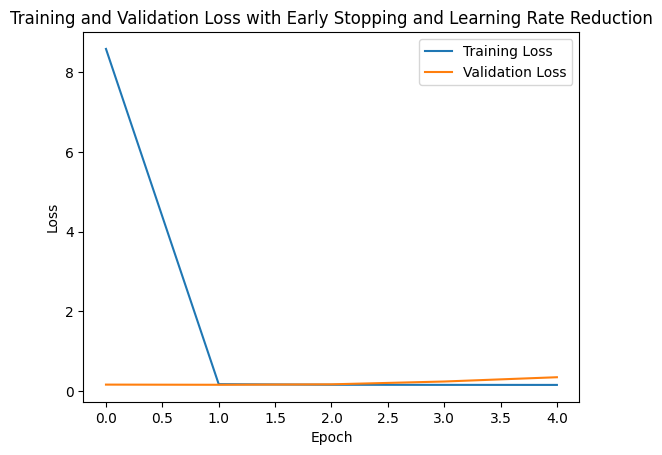

Training stopped after 5 epochs


In [30]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Increased patience to allow more room for training
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,  # Allow a bit more room for learning rate reduction
    min_lr=1e-6
)

# Train the model with early stopping and learning rate reduction
history = model.fit(
    X_train,
    y_train,
    epochs=50,  # Reduced number of epochs to avoid overfitting
    batch_size=16,  # Adjust batch size as needed
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss with Early Stopping and Learning Rate Reduction')
plt.show()

# Print details about the early stopping
print(f"Training stopped after {len(history.history['loss'])} epochs")


In [31]:
# Function to predict the next 30 days
def predict_next_30_days(model, data, n_predictions):
    predictions = []
    current_seq = data[-16:]  # Start with the last available 2-day sequence
    for _ in range(n_predictions):
        pred = model.predict(current_seq.reshape((1, 16, data.shape[1], data.shape[2], 1)))
        predictions.append(pred[0])
        current_seq = np.append(current_seq[1:], pred, axis=0)  # Shift and include the new prediction
    return np.array(predictions)

# Predict the next 30 days
n_predictions = 30
predicted_next_30_days = predict_next_30_days(model, resampled_data_cnn, n_predictions)

print(f'Predicted shape for the next 30 days: {predicted_next_30_days.shape}')

1/1 [==============================] - 0s 51ms/step
Predicted shape for the next 30 days: (30, 92, 179, 1)


Shape of resampled_data_cnn: (364, 92, 179, 1)
Shape of predicted_next_30_days: (30, 92, 179, 1)


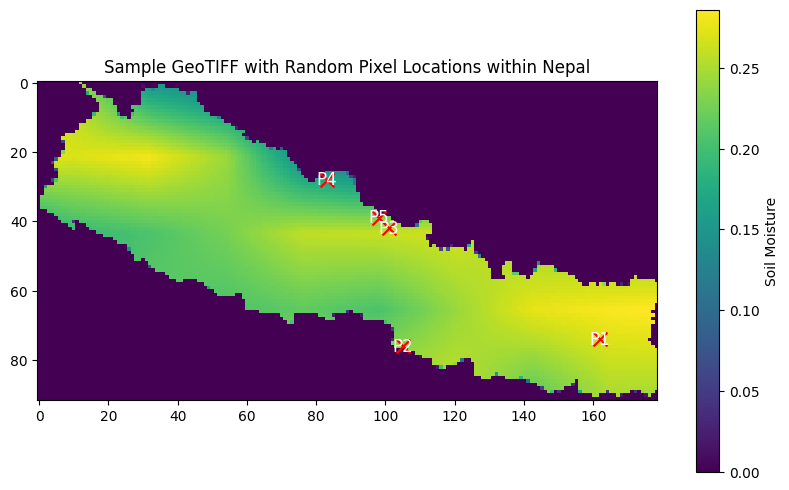

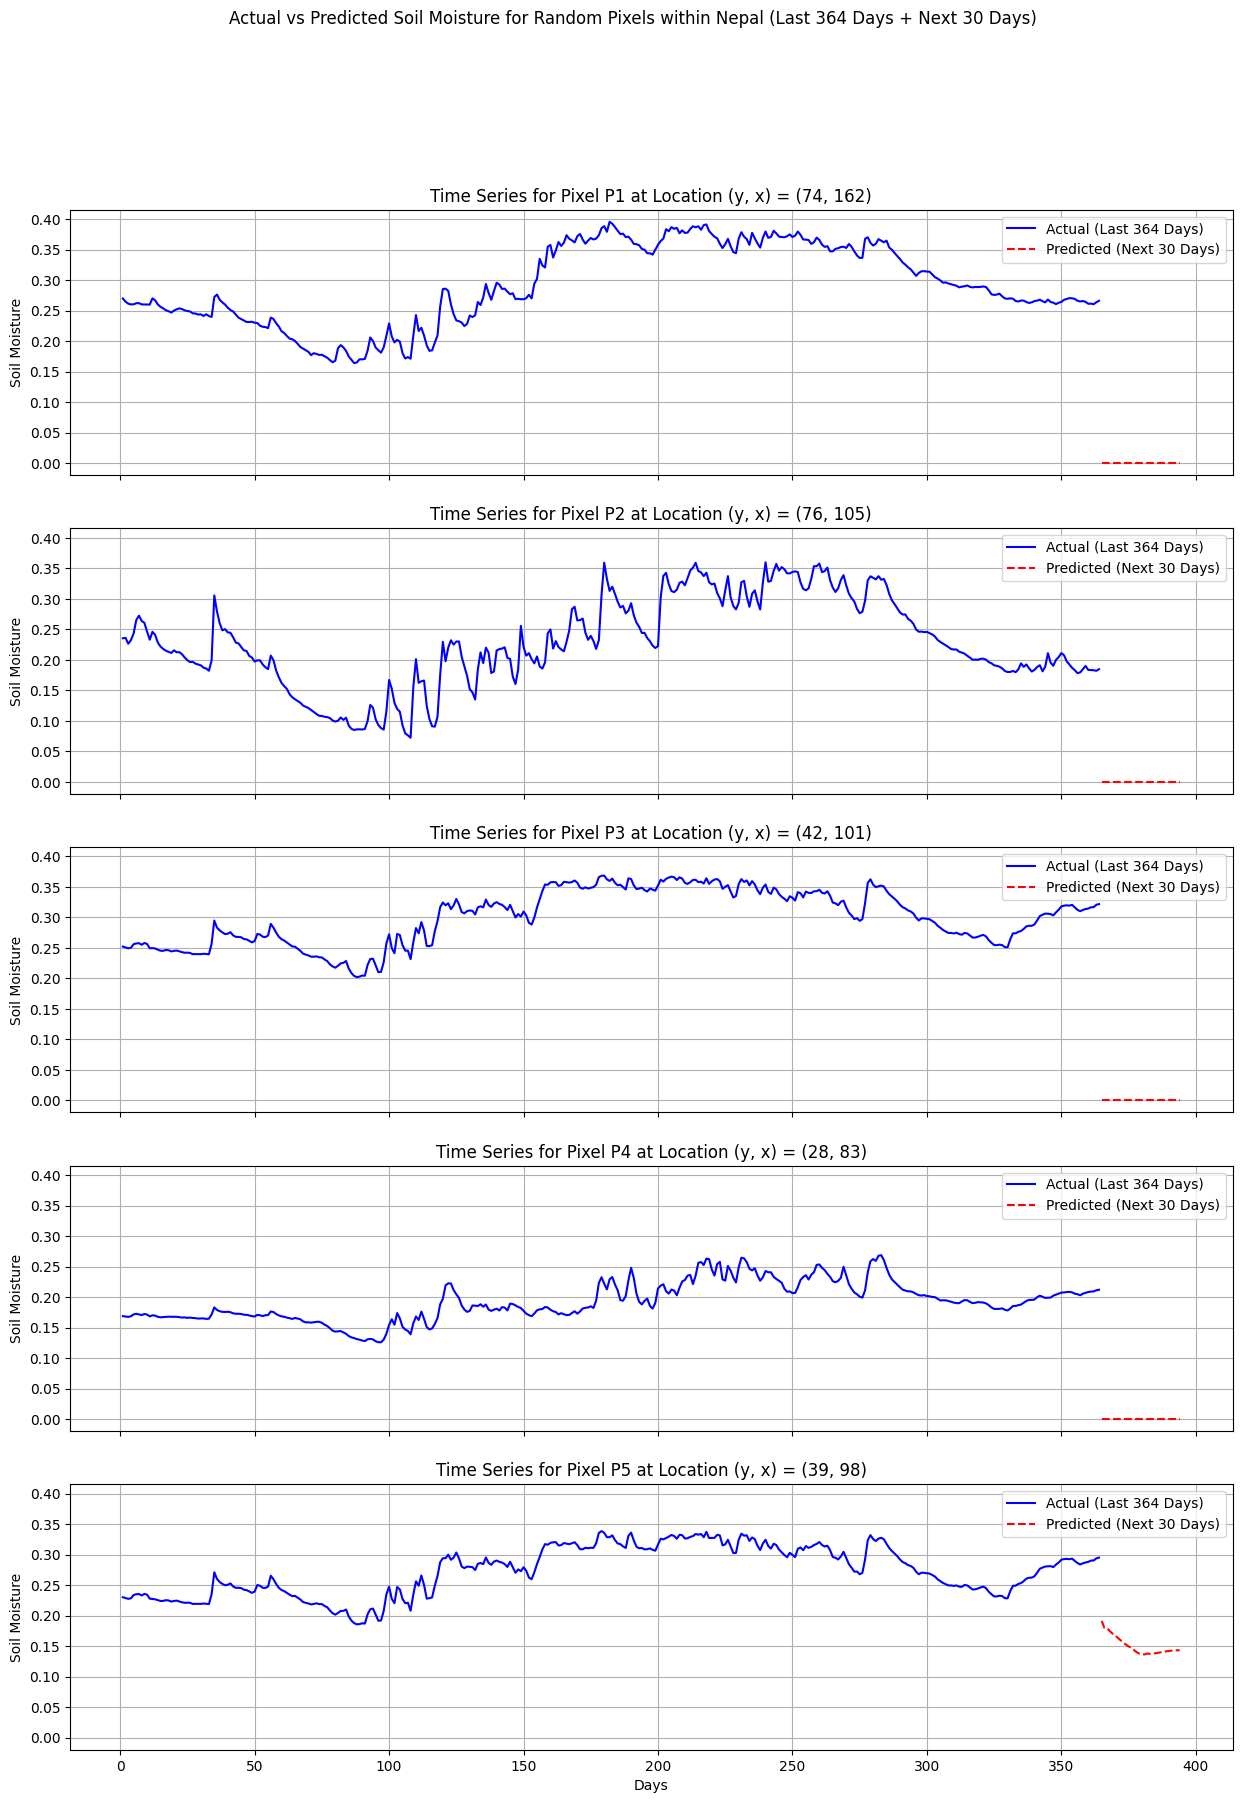

Pixel P1 at (y, x) = (74, 162):
Actual last 364 days:
[0.26999116 0.2647965  0.26145822 0.2602642  0.26044238 0.2623043
 0.26231217 0.26023972 0.26012605 0.26010925 0.2600331  0.2702355
 0.26680228 0.2602522  0.25636846 0.253774   0.2506993  0.24914593
 0.24695352 0.2500639  0.2522141  0.2538051  0.25263023 0.25041413
 0.24946664 0.2485994  0.24560751 0.24531618 0.2436768  0.24399039
 0.2413002  0.24416816 0.24113962 0.23973395 0.27242592 0.2763636
 0.26782256 0.26355517 0.25997117 0.25482813 0.2511196  0.24865918
 0.24354921 0.23859929 0.23629844 0.23392159 0.23146845 0.2314215
 0.2318895  0.23023783 0.22972429 0.22533768 0.22357768 0.22313789
 0.22139329 0.23860037 0.23646228 0.22936706 0.22397192 0.21629073
 0.21343744 0.20845236 0.2042285  0.20314108 0.2003463  0.19561052
 0.19049238 0.18780842 0.18520007 0.18252537 0.17709653 0.18033202
 0.17906739 0.1774036  0.17779218 0.17520185 0.1728975  0.16886076
 0.16548736 0.16792573 0.18842667 0.19352211 0.18988517 0.18396999
 0.17489241 

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Assuming `resampled_data_cnn` and `predicted_next_30_days` are already loaded in your environment

# Print the shapes of the arrays to debug
print("Shape of resampled_data_cnn:", resampled_data_cnn.shape)
print("Shape of predicted_next_30_days:", predicted_next_30_days.shape)

# Display the original GeoTIFF file with random pixel locations
# Using one of the bands to display
sample_band_index = 0
sample_data = resampled_data_cnn[sample_band_index, :, :, 0]

# Create a mask for valid (non-background) pixels
valid_mask = sample_data > 0
valid_pixels = np.argwhere(valid_mask)

# Select 5 random valid pixel locations
random_pixel_indices = random.sample(range(valid_pixels.shape[0]), 5)
random_pixels = valid_pixels[random_pixel_indices]

# Display the GeoTIFF image and plot random pixels
plt.figure(figsize=(10, 6))
plt.imshow(sample_data, cmap='viridis')
plt.colorbar(label='Soil Moisture')
plt.title('Sample GeoTIFF with Random Pixel Locations within Nepal')

# Plot the random pixels
for idx, (y, x) in enumerate(random_pixels):
    plt.scatter(x, y, c='red', s=100, marker='x')
    plt.text(x, y, f'P{idx+1}', color='white', fontsize=12, ha='center', va='center')

plt.show()

# Extract and plot time series for each random pixel
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True, sharey=True)

for idx, (y, x) in enumerate(random_pixels):
    actual_last_364_days = resampled_data_cnn[-364:, y, x, 0]  # Shape (364,)

    # Ensure predictions are aligned with the same spatial locations
    predicted_next_30_days_flat = predicted_next_30_days[:, y, x, 0]  # Shape (30,)

    combined_days = np.arange(1, 395)  # 364 actual + 30 predicted
    combined_data = np.concatenate((actual_last_364_days, predicted_next_30_days_flat), axis=0)  # Shape (394,)

    axs[idx].plot(range(1, 365), actual_last_364_days, label='Actual (Last 364 Days)', color='blue')
    axs[idx].plot(range(365, 395), predicted_next_30_days_flat, label='Predicted (Next 30 Days)', linestyle='--', color='red')
    axs[idx].set_title(f'Time Series for Pixel P{idx+1} at Location (y, x) = ({y}, {x})')
    axs[idx].set_ylabel('Soil Moisture')
    axs[idx].legend()
    axs[idx].grid(True)

axs[-1].set_xlabel('Days')
plt.suptitle('Actual vs Predicted Soil Moisture for Random Pixels within Nepal (Last 364 Days + Next 30 Days)')
plt.show()

# Optional: Print time series values for debugging
for idx, (y, x) in enumerate(random_pixels):
    print(f"Pixel P{idx+1} at (y, x) = ({y}, {x}):")
    print("Actual last 364 days:")
    print(resampled_data_cnn[-364:, y, x, 0])
    print("Predicted next 30 days:")
    print(predicted_next_30_days[:, y, x, 0])
